In [1]:
%matplotlib inline
# plot the molecule in 3D in an interactive window
# %matplotlib widget
%config InlineBackend.figure_format = 'retina'

In [2]:
# get current working directory
import os, sys
pwd = os.getcwd()
# append ../ to the sys path to access the coarsegraining package
sys.path.append(pwd + '/src/')

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from coarsegrainer.plotting import plot_line_3D, plot_graph
from experimentlogger import ExperimentLogger

# Quadratic Bonds + LJ loop
Define an energy function which uses a quadratic potential for bonds and LJ for forming a loop. 
It consists of:
1. a strong backbone line graph LJ, where every node is attracted to the next
2. a weaker loop LJ, where every l-th pair of nodes are attracted 

In [4]:
ls results

CG_Bond_LJ_experiment2024-02-09-21.csv   logs/
CG_Bond_LJ_experiment2024-02-10-02.csv   test2024-02-09-22.csv
CG_Bond_LJ_experiment2024-02-10-03.csv   test2024-02-09-23.csv
CG_Bond_LJ_experiments2024-02-10-03.csv


In [37]:
exp_logger = ExperimentLogger(previous_results_csv='./results/CG_Bond_LJ_experiments2024-02-10-03.csv')
# exp_logger = ExperimentLogger(save_prefix='../results/CG_Bond_LJ_experiment') 


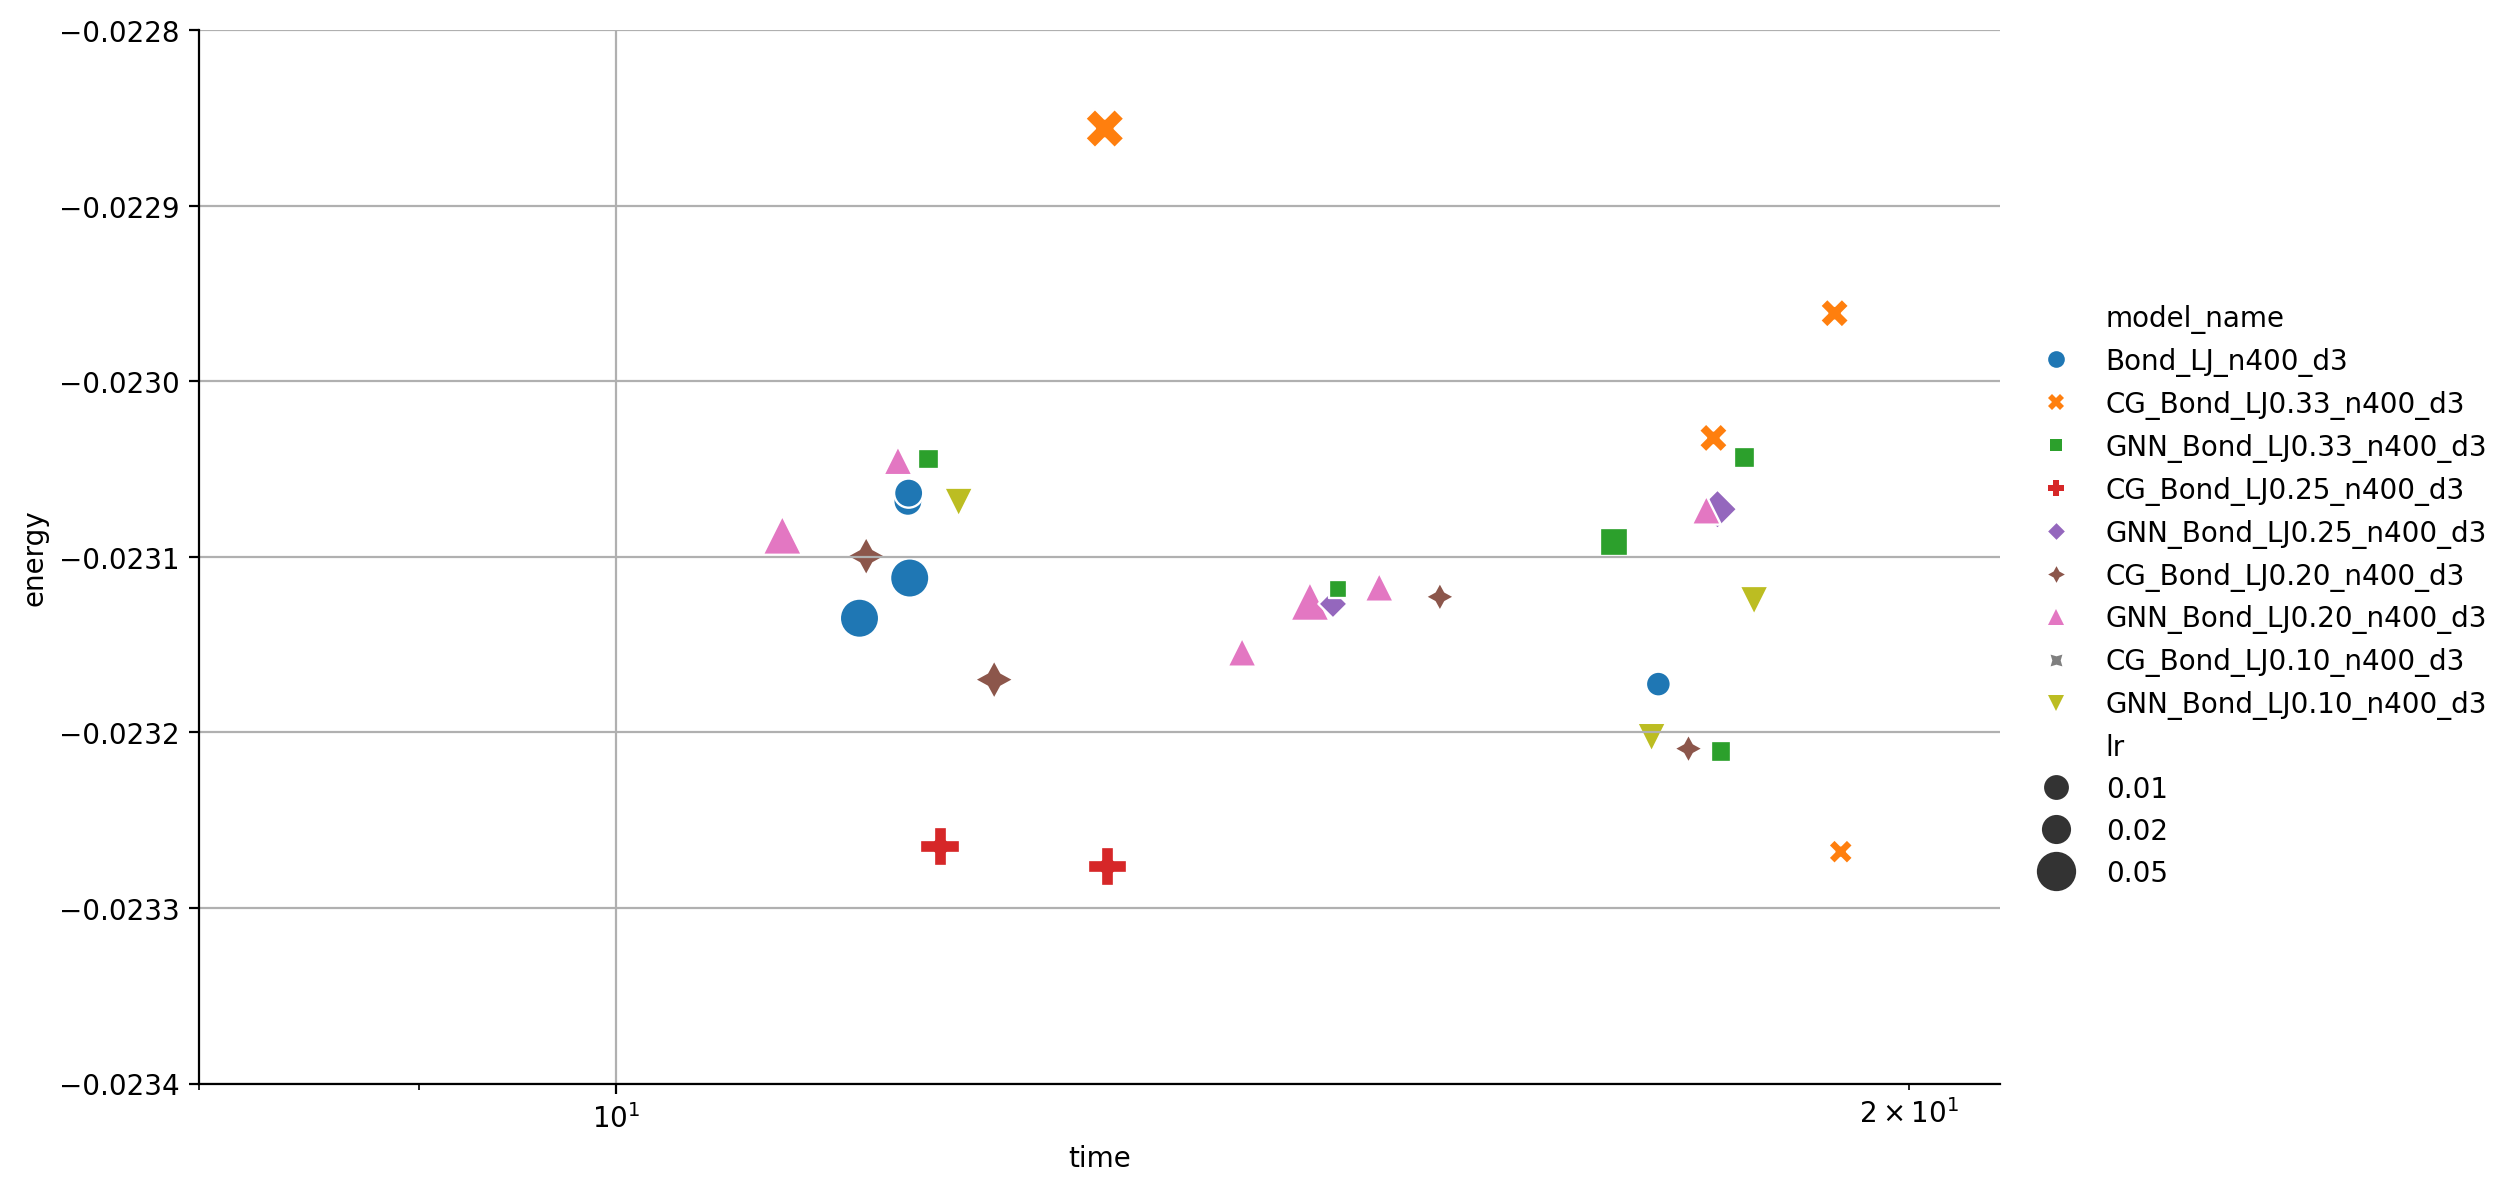

In [38]:
df = exp_logger.to_dataframe()
# plot the filtered dataframe using sns directly on df
# sns.relplot(data=df, x='time', y='energy', hue='model_name', style='model_name', kind='scatter', size='lr', height=6, aspect=1.7)
# plot with larger marker size 
sns.relplot(data=df, x='time', y='energy', hue='model_name', style='model_name', kind='scatter', size='lr', height=6, aspect=1.7, sizes=(80, 200))

plt.ylim(-.0234, -.0228)
plt.xlim(8,21)
plt.xscale('log')
plt.grid()